#  Прогнозирование заказов такси

По заказу компании «Чётенькое такси» необходимо построить модель машинного обучения, предсказывающую  количество заказов такси на следующий час. В соотвутствии с условием заказчика метрикой качества необходимо избрать *RMSE*, значение которой на тестовой выборке не должно превышать 48.

Для построения модели предоставлены исторические данные о заказах такси в аэропортах. 

## Подготовка

Импортируем необходимые библиотеки

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import random

from numpy.random import RandomState
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

Построение модели, прогнозирующей количество заказов такси на следующий час, являетя работой с временными рядами для которой нам необходимо столбец времени перевести в тип  "datetime64" и представить его в виде индекса таблицы. для этого при чтении файла  в функцию read_csv() передадим аргументы  parse_dates=[0], который изменит тип данных, и index_col=0, благодаря которому столбец с датой станет индексом.

In [130]:
try:
    data = pd.read_csv("C:\\Users\\User\\Downloads\\taxi.csv", parse_dates=[0], index_col=0)# 
    
except:

    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0) 


data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы получили датафрейм, состоящий из 26496 объектов, индексом является столбец "datetime" типа "Datetime". Методом index.is_monotonic проверим соблюдена ли в нем хронология, а также посмотрим диапазон времени, выведя минимальное и максимальное значения "datetime" 

In [132]:
if data.index.is_monotonic==True:
    print("Хронология солбюдена")
    print("диапазон времени с",data.index.min(),"до", data.index.max())
else:
    print("Хронологияя нарушена")

Хронология солбюдена
диапазон времени с 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Хронология в столбце "datetime" соблюдена, данные за 6 месяцев находятся во временном диапазоне с 0 часов 01.03.2018 по 23 час.50 мин.31.08.2018. 

По условию проекта нам необходимо прогнозировать количество заказов такси на следующий час. Для этого проведем ресемплирование столбца "datetime" функцией resample() с интервалом в 1 час и вызовем метод sum(), просуммирующий общее количпство заказов за час.

In [133]:
data = data.resample('1H').sum() 
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<b>Вывод:</b> Поставленная задача (построение модели предсказаний количества заказов такси на следующий час) являетя работой с временными рядами. В указанной связи при чтении файла с данными, представленными заказчиком,   столбец времени переведен в тип "datetime64" и представлен виде индекса таблицы. 
    
Исходный датафрейм, состоит из 26496 объектов, индексом стал столбец "datetime", хронология в котором соблюдена, данные за 6 месяцев находятся во временном диапазоне с 0 часов 01.03.2018 по 23 час.50 мин.31.08.2018.

Для построения модели прогнозирования на час вперед проведено ресемплирование столбца "datetime" с интервалом в 1 час. Количество объектов в датафрейме, состоящем из врменных значений в качестве индекса и столбца с количеством заказов за соответствующий час, стало 4416.
</div>

## Анализ

После ресемплирования с часовым интервалом в нашем датафрейме  осталось 4416 объектов с интервалом 00 час. 01.03.2018 - 23 час.31.08.2018. Посмотрим на колебания количества заказов на графике. Для снижения колебаний применим скользящее среднее и стандартное вызовом функции rolling() с размером окна 8 и построим график

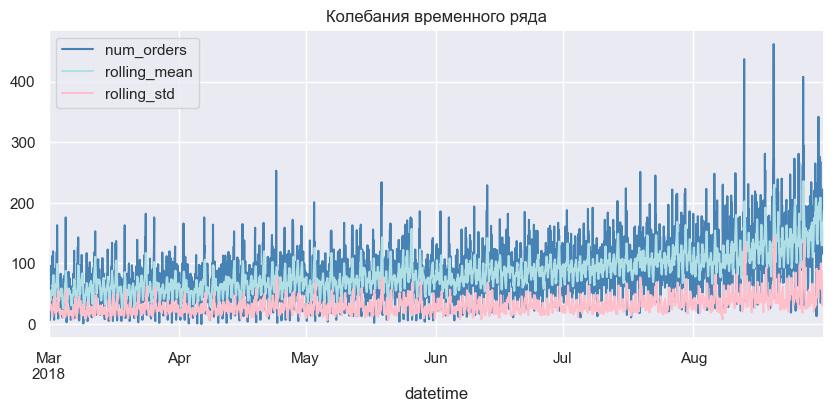

In [134]:
sns.set_style('darkgrid')
ax = data['num_orders'].plot(figsize=(10, 4), color = 'steelblue', label='num_orders')
ax = data['num_orders'].rolling(8).mean().plot(figsize=(10, 4), color="powderblue", label='rolling_mean')
ax = data['num_orders'].rolling(8).std().plot(figsize=(10, 4), color="pink", label='rolling_std')
ax =plt.title('Колебания временного ряда')
ax =plt.legend()

Временной ряд нельзя назвать стационарным, потому что его среднее значение сначала (с марта по июнь) медленее, а потом заметно быстрее растет, в такой же последовательности меняется и стандартное отклонение. 

С помощью функции seasonal_decompose(), примененной к 'num_orders', построим графики трендовых, сезонныч явлений и посмотрим на шум.

In [135]:
decomposed = seasonal_decompose(data['num_orders'])

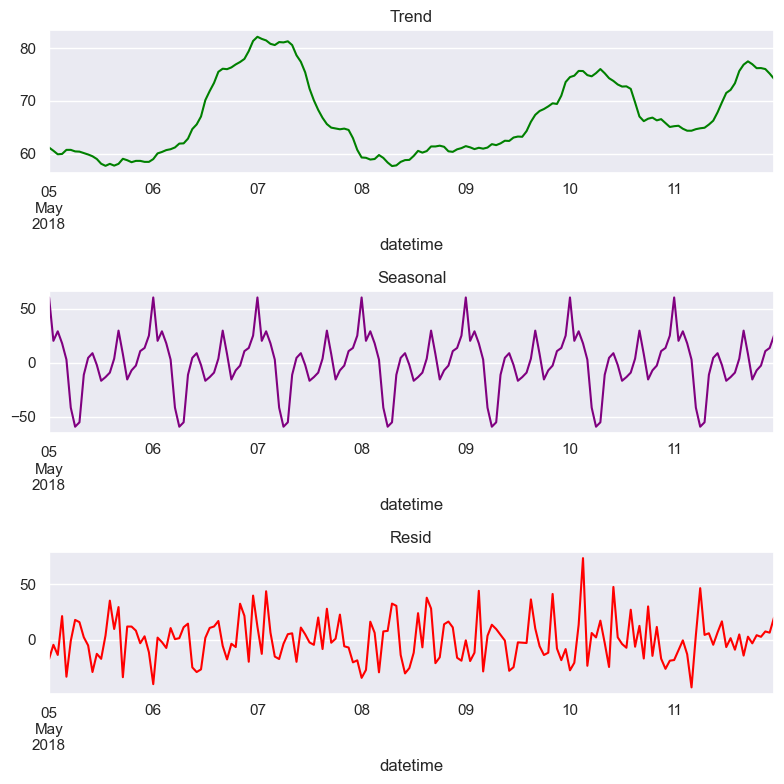

In [136]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend['2018-05-05':'2018-05-11'].plot(ax=plt.gca(),color='green')
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-05-05':'2018-05-11'].plot(ax=plt.gca(), color = 'purple')
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-05-05':'2018-05-11'].plot(ax=plt.gca(),color='red' )
plt.title('Resid')
plt.tight_layout()

На графике 'Trend' видно, что трендовым является увеличение вызовов такси в третий, пятый и седьмой дни недели. График 'Seasonal' показывает, что колебания в течение суток - сезонное явление. Остатки на графике 'Resid' необъяснимы. 

Поскольку поставлена задача спрогнозировать количечтво вызовов такси на следующий час, изучим закономерности в течение суток

Text(0.5, 1.0, 'Seasonal')

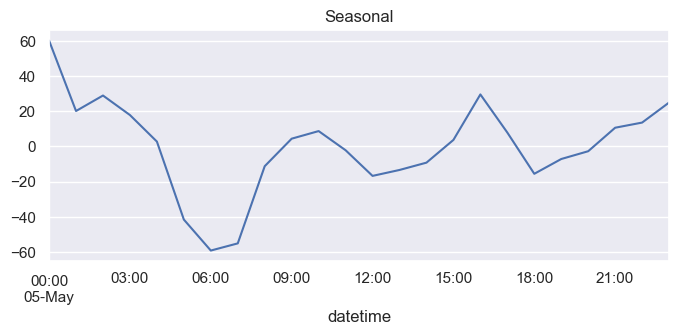

In [137]:
plt.figure(figsize=(8, 3))

ax = decomposed.seasonal['2018-05-05 00:00:00':'2018-05-05 23:00:00'].plot()
plt.title('Seasonal')

На графике видно, что пик вызовов такси приходится на 00:00 часов, высокое количество заказов также наблюдается с 9:00 до 10:00 и с 15:00 до 16:00. Минимальное количество - в 6:00 часов.  

Чтобы сделать ряд стационарным, дополним датафрейм столбцом с разностью временного ряда, для получения которого к "num_orders" применим метод shift() с аргументом fill_value=0 для заполнения пропущенных значений. Построим график, на котором также посмотрим скользящие среднее значение и стандартное отклонение по новому столбцу

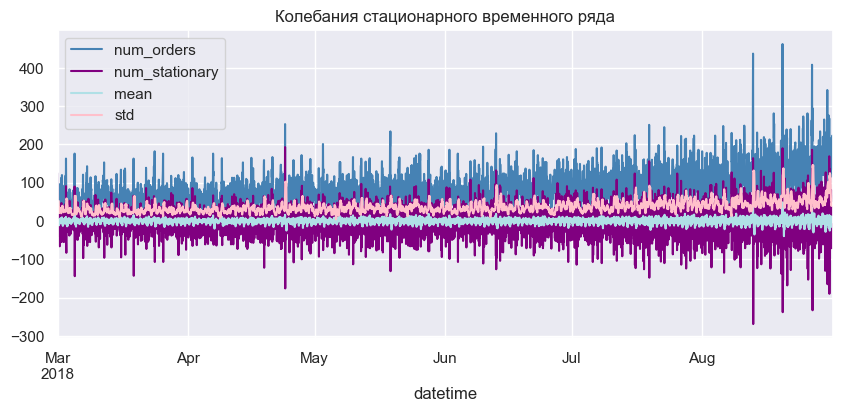

In [138]:
data['num_stationary'] = data['num_orders'] - data['num_orders'].shift(fill_value=0)
data['mean'] = data['num_stationary'].rolling(8).mean()
data['std'] = data['num_stationary'].rolling(8).std()
data.plot(figsize=(10, 4), color = ['steelblue', 'purple','powderblue', 'pink'])
ax=plt.title('Колебания стационарного временного ряда')

Временной ряд 'num_stationary', представленный разностями исходного временного ряда "num_orders" стал более стационарен, что особенно видно на графике скользящего среднего значения. Его стандартное отклонение более колеблется,но все равно стабильнее чем до преобразования. 

 <b>Вывод:</b>
Изучением данных установлено, что временной ряд не является стационарным, его среднее значение сначала (с марта по июнь) медленее, а потом заметно быстрее растет, в такой же последовательности меняется и стандартное отклонение.

На графиках, значений, выведенных с помощью функции seasonal_decompose(), примененной к 'num_orders', видно, что трендовым является увеличение вызовов такси в третий, пятый и седьмой дни недели. Суточные колебания числа вызовов - сезонное явление. 
    
На графике вызовов за сутки видно, что пик такси приходится на 00:00 часов, высокое количество заказов также наблюдается с 9:00 до 10:00 и с 15:00 до 16:00. Минимальное количество - в 6:00 часов.
    
Данные разностией временного ряда более стационарны исходного, что особенно заметно на графике скользящего среднего значения. Стандартное отклонение более колеблется,но все равно стабильнее чем до преобразования.
</div>

## Обучение

Построим несколько моделей, предсказывающих количество вызовов такси на следующий час:
-  "Решающее дерево";
-  "Случайный лес";
модели градиентного бустинга:
-  LGBMRegressor;
-  CatBoostRegressor;
-  XGBRegressor.

### Создание признаков

Пишем функцию для создания признаков, состоящих из календарных признаков: месяц, день, день недели и час, отстающих значений и скользящего среднего целевого признака. Целевым признаком станет 'num_orders' после ресемплирования с часовым интервалом. 

In [139]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()    


Передаем в качестве агрументов этой функции датафрейм с нестационарным рядом в целевом признаке, максимальное количество отстающих значений укажем в количестве, равном количеству часов в сутках (у нас прогнозирование на следующий час, суточные колебания являются сезонными), скользящему среднему установим окно со значением 6.

In [140]:
# Очищаем от признаков, созданных для анализа
data = data.drop(['num_stationary','mean', 'std'], axis=1)

# Передаем функции
make_features(data, 24, 6)
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Делим выборку на обучающуюи тестовую в соотношении 9:1 (в соответствии с условием проекта). Поскольку соблюдение хронологии событий важно для нашего прогнозирования, во избежание перемешивания данных задаем параметр shuffle=False. Методом dropna() удаляем получившиеся пропущенные значения.

In [141]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
train.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.333333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.166667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,84.666667
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,87.000000
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.666667


Учебный и тестовый наборы данных делим на признаки и целевой признак и проверяем размеры выборок. 

In [142]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [143]:
def shape(sample):
    print('Размер выборки составляет:', sample.shape)
    
shape(features_train)
shape(target_train)
shape(features_test)
shape(target_test)

Размер выборки составляет: (3950, 29)
Размер выборки составляет: (3950,)
Размер выборки составляет: (442, 29)
Размер выборки составляет: (442,)


Проверяем соблюдение хрогологии в учебном и тестовом наборе данных признаков

In [144]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Проверяем соблюдение хрогологии в учебном и тестовом наборе данных целевого признака

In [145]:
print(target_train.index.min(), target_train.index.max())
print(target_test.index.min(), target_test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разделились корректно по размеру выборок и с соблюдением хронологии

### Подбор гиперпараметров и обучение моделей

Для подбора гиперпараметров используем модуль GridSearchCV, для кросс-валидации используем специальный в качестве кросс-валидатор временных рядов TimeSeriesSplit(). По условию проекта метрикой качества является RMSE, на улучшение которой мы будем ориентироваться при подборе гиперпараметров. В указанной связи аргументу  scoring передадим параметр 'neg_root_mean_squared_error', который нам выведет лучший показатель RMSE (с отрицательным знаком).

In [146]:
tscv = TimeSeriesSplit() 

#### 'Решающее дерево'

In [147]:
%%time

parametrs = {'min_samples_leaf': range (1,11,2),
             'max_depth': range (1,10)}
tree = GridSearchCV(DecisionTreeRegressor(), parametrs, scoring='neg_root_mean_squared_error',cv=tscv)
tree.fit(features_train,target_train)

Wall time: 3.36 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 11, 2)},
             scoring='neg_root_mean_squared_error')

In [148]:
print("Лучшие гиперпараметры для модели 'Решающее дерево':", tree.best_params_)
print('RMSE:', round((tree.best_score_*-1),2)) 

Лучшие гиперпараметры для модели 'Решающее дерево': {'max_depth': 5, 'min_samples_leaf': 7}
RMSE: 29.0


#### 'Случайный лес'

In [149]:
%%time

rf_params = {'n_estimators': [10, 20, 30, 40],
             'max_features': ['auto', 'sqrt'],
             'max_depth': [2,4,6,8],
             'min_samples_leaf': [1, 2, 3, 4]}
forest = GridSearchCV(RandomForestRegressor(),rf_params,scoring='neg_root_mean_squared_error', n_jobs=-1, cv = tscv, verbose=2)
forest.fit(features_train,target_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Wall time: 14.9 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [10, 20, 30, 40]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [150]:
print("Лучшие гиперпараметры для модели 'Случайный лес':", forest.best_params_)
print('')
print('RMSE:', round((forest.best_score_*-1),2))

Лучшие гиперпараметры для модели 'Случайный лес': {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 30}

RMSE: 25.68


#### Модель градиентного бустинга LGBMRegressor

In [151]:
%%time

lg = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 7, 10],
    'verbose' : [-1],
    'force_col_wise': [True],
    'num_leaves' : [30, 130, 200]
    }
lgb = GridSearchCV(estimator=lg, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
lgb.fit(features_train,target_train)

Wall time: 3.92 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'force_col_wise': [True],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [30, 130, 200], 'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

In [152]:
print("Лучшие гиперпараметры для модели 'lgb_df':", lgb.best_params_)
print('')
print('RMSE:', round((lgb.best_score_*-1),2))

Лучшие гиперпараметры для модели 'lgb_df': {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30, 'verbose': -1}

RMSE: 24.73


#### Модель градиентного бустинга XGBRegressor

In [153]:
%%time

xg = XGBRegressor()

params = {
        'n_estimators': [10,50],
        'max_depth': [3, 8],
        'eta': [0.5, 1]
        }
xgb = GridSearchCV(xg, params, n_jobs=-1, scoring = 'neg_root_mean_squared_error', cv = tscv)

xgb.fit(features_train, target_train)

Wall time: 1.49 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.5, 1], 'max_depth': [3, 8],
                         'n_estimators': [10, 50]},
             scoring='neg_root_mean_squared_error')

In [154]:
print("Лучшие гиперпараметры для модели 'xgb':", xgb.best_params_)
print('')
print('RMSE:', round((xgb.best_score_*-1),2))

Лучшие гиперпараметры для модели 'xgb': {'eta': 0.5, 'max_depth': 3, 'n_estimators': 50}

RMSE: 26.23


#### Модель градиентного бустинга CatBoostRegressor

In [155]:
%%time

cb = CatBoostRegressor(verbose = False)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [3, 5, 8],
        'iterations': [100, 150, 200]    
    }

cat = GridSearchCV(cb, grid, cv=tscv, n_jobs = -1, scoring = 'neg_root_mean_squared_error')#, verbose = False)
cat.fit(features_train,target_train)

Wall time: 6min 8s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000027B91CEBDF0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 150, 200],
                         'l2_leaf_reg': [3, 5, 8],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_root_mean_squared_error')

In [156]:
print("Лучшие гиперпараметры для модели 'cat':", cat.best_params_)
print('')
print('RMSE:', round((cat.best_score_*-1),2))

Лучшие гиперпараметры для модели 'cat': {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

RMSE: 24.37


 <b>Вывод:</b> Нами построены несколько моделей прогнозирования "Решающее дерево", "Случайный лес", модели градиентного бустинга:LGBMRegressor, CatBoostRegressor, XGBRegressor.
    
Целевым признаком является 'num_orders' с данными за 1 час по соответствующему индекс. Признаки, созданные специальной функцией,  состоят из календарных значений: месяц, день, день недели и час, отстающих значений и скользящего среднего целевого признака.  
Максимальное количество отстающих значений задано 24 (по количеству часов в сутках), окно скользящего среднего - 6.
    
В соответствии с условием проекта созданный для прогнозирования датафрейм разделен на обучающую и тестовую выборки в соотношении 9:1.   
    
Для подбора гиперпараметров использован модуль GridSearchCV, для кросс-валидации  специальный кросс-валидатор временных рядов TimeSeriesSplit(). При подборе гиперпараметров аргументу scoring передан параметр 'neg_root_mean_squared_error'. По каждой модели получены данные о наивысшем RMSE и гиперпараметрах, при которых он получен. 

## Тестирование

Для для выбора лучшей модели и ее тестирования сопоставим метрики качества всех моделей, которые мы вывели при обучении. Для этого построим таблицу и диаграмму. 

,model,RMSE
0,tree,29.00
1,forest,25.68
2,lgb,24.73
3,xgb,26.23
4,cat,24.37


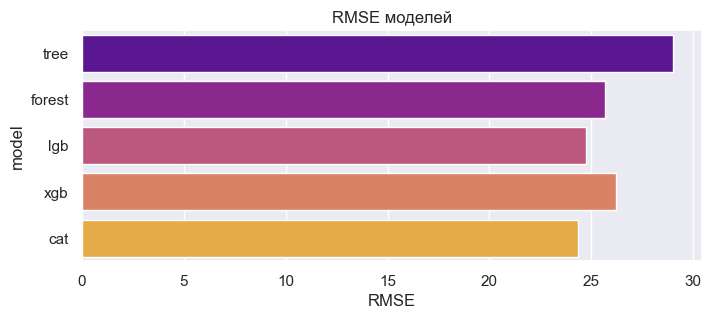

In [157]:
n = [['tree', round((tree.best_score_*-1),2)], 
      ['forest', round((forest.best_score_*-1),2)], 
      ['lgb', round((lgb.best_score_*-1),2)],
      ['xgb', round((xgb.best_score_*-1),2)],
      ['cat', round((cat.best_score_*-1),2)]]
v = pd.DataFrame(n, columns=['model', 'RMSE'])

sns.set (font_scale= 1 )
plt.figure(figsize=[8,3])
plt.title('RMSE моделей')
ax = sns.barplot(x='RMSE', y="model", data=v, palette='plasma')
v

RMSE построенных моделей варируется в пределах от 24.37 до 29.00, что значительно меньше требуемого условием проекта (не более 48). 

Самое низкое значение метрики RMSE у модели градиентного бустинга, построенной средствами библиотеки catboost и составляет 24.37. Но подбор гиперпараметров и обучение данной модели занимает более 6 мин., что на порядок больше по сравнению с другими моделями. 

В этой связи для тестирования выберем другую модель градиентного бустинга - построенную средствами библиотеки lightgb, поскольку ее метрика качества (24.73) незначительно превышает метрику модели catboost, а времени на подбор гиперпараметров и обучение затрачивается чуть более 4 сек.

Тестируем модель градиентного бустинга lgb, построенную средствами библиотеки lightgb с гиперпараметрами, подобранными GridSearchCV.  

In [158]:
# получаем предсказания на тестовой выборке
prediction_lgb = lgb.predict(features_test) 

# выводим значение RMSE
print('RMSE модели lgb на тестовой выборке:', round((mean_squared_error(target_test, prediction_lgb)**0.5),2))


RMSE модели lgb на тестовой выборке: 39.79


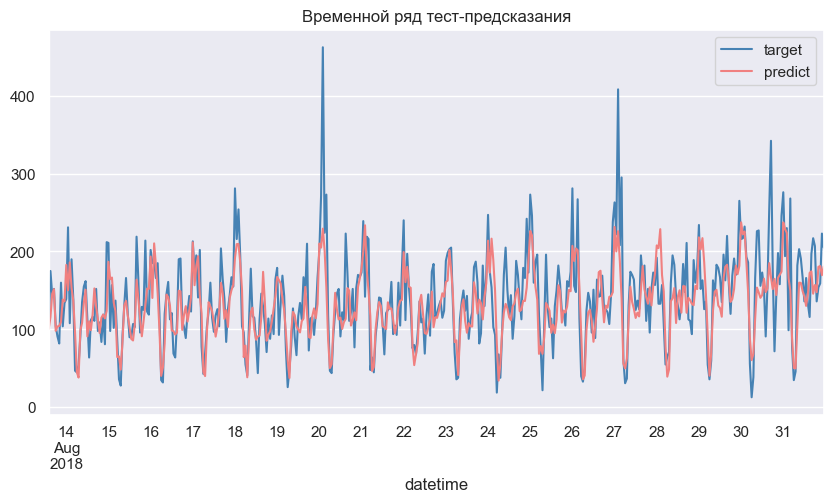

In [159]:
model_data = pd.DataFrame({"target":target_test, "predict":prediction_lgb})
ax = model_data.plot(figsize=(10, 5), color=['steelblue', 'lightcoral'])
ax =plt.title('Временной ряд тест-предсказания')

Погрешность в предсказаниях имеет тенденцию к занижению значений, особенно в так называемые пиковые периоды. 

<b>Итоговый вывод:</b>
По заказу компании «Чётенькое такси» построена модель машинного обучения, предсказывающая количество заказов такси на следующий час. Для построения модели предоставлены исторические данные о заказах такси в аэропортах.
    
Построение данной модели предсказаний являетя работой с временными рядами в связи с чем при чтении файла, представленного заказчиком, столбец времени переведен в тип "datetime64" и представлен виде индекса таблицы. Исходный датафрейм, состял из 26496 объектов, индексом стал столбец "datetime", хронология в котором соблюдена, данные за 6 месяцев находятся во временном диапазоне с 0 часов 01.03.2018 по 23 час.50 мин.31.08.2018.

Для построения модели прогнозирования на час вперед проведено ресемплирование столбца "datetime" с интервалом в 1 час, после чего количество объектов в датафрейме стало 4416.
    
Данные временного ряда после ресемплирования не стационарны, его среднее значение сначала (с марта по июнь) медленее, а потом заметно быстрее растет, в такой же последовательности меняется и стандартное отклонение. Анализ данных в масштабе недели свиделеьствует о том, что трендовым является увеличение вызовов такси в третий, пятый и седьмой дни недели, сезонным являются суточные колебания числа вызовов. В тчение суток пик вызовов такси приходится на 00:00 часов, высокое количество заказов также наблюдается с 9:00 до 10:00 и с 15:00 до 16:00. Минимальное количество - в 6:00 часов.

Для построения моделей прогнозирования создан датафрейм, в котором целевым признаком является 'num_orders' с данными за 1 час по соответствующему индексу, а признаки, созданны специальной функцией и состоят из календарных значений: месяц, день, день недели и час, отстающих значений и скользящего среднего целевого признака. Максимальное количество отстающих значений задано 24 (по количеству часов в сутках), окно скользящего среднего - 6. Данные разделены на обучающую и тестовую выборки в соотношении 9:1.  
    
Всего построено 5 моделей прогнозирования "Решающее дерево", "Случайный лес", модели градиентного бустинга: LGBMRegressor, CatBoostRegressor, XGBRegressor. 
 
Подбор гиперпараметров осуществлен посредством GridSearchCV с примененением кросс-валидатора временных рядов TimeSeriesSplit() и  аргументом scoring='neg_root_mean_squared_error'. По каждой модели получены данные о наивысшем RMSE и гиперпараметрах, при которых он получен. 
    
RMSE всех моделей варируется в пределах от 24.37 до 29.00, что значительно меньше требуемого условием проекта (не более 48). 
Самое низкое значение метрики у модели градиентного бустинга, построенной средствами библиотеки catboost и составляет 24.37. Но подбор гиперпараметров и обучение данной модели занимает более 6 мин., что на порядок больше по сравнению с другими моделями. В этой связи для тестирования выбрана другая модель градиентного бустинга - построенная средствами библиотеки lightgb, поскольку ее метрика качества (24.73) незначительно превышает минимальную (у catboost), а времени на подбор гиперпараметров и обучение затрачивается чуть более 3 сек.
    
На тестовой выборке RMSE модели lgb составило 39.79, что значительно меньше установленного заказчком условия (не более 48). В указанной связи для прогнозирования количества заказов такси на следующий час заказчику предлагается модель градиентного бустинга, построенная средствами библиотеки lightgb при гиперпараметрах 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30.    </div>